# Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
RUN_DIR = 'runs/focus2/'
df = pd.concat([pd.read_parquet(RUN_DIR+f) for f in os.listdir(RUN_DIR)])
len(df)

17661952

# Pre-process

### Get item counts

In [3]:
item_cols = [col for col in df.columns if 'items' in col]
item_cols

['characters[0].items[0].__class__',
 'characters[0].items[1].__class__',
 'characters[0].items[2].__class__',
 'characters[0].items[3].__class__',
 'characters[0].items[4].__class__',
 'characters[0].items[5].__class__']

In [4]:
item_types = df[df['after']][item_cols[0]].dropna().unique()
item_types

array(['CommonItem', 'Clue', 'Spell', 'UniqueItem', 'Ally'], dtype=object)

In [5]:
for i, item_type in enumerate(item_types):
    df[item_type]  = (df[item_cols] == item_types[i]).sum(axis=1)

In [6]:
df[['attempt_id', 'after']+item_types.tolist()]

,attempt_id,after,CommonItem,Clue,Spell,UniqueItem,Ally
0,3dc7d365dce142f6b1efbab2efd537f6,False,0,0,0,0,0
1,3dc7d365dce142f6b1efbab2efd537f6,True,0,0,0,0,0
2,160e4772283149c4b1654ed342e4e872,False,0,0,0,0,0
3,160e4772283149c4b1654ed342e4e872,True,0,0,0,0,0
4,6b0ae45a3f3c4ee3a307838f036781d1,False,0,0,0,0,0
...,...,...,...,...,...,...,...
180219,1104969f70154419a68da592a890f7da,True,1,2,1,0,0
180220,7e5e4d74d2ed48908cfcbd3ce36b60f4,False,0,3,0,0,0
180221,7e5e4d74d2ed48908cfcbd3ce36b60f4,True,0,0,0,0,0
180222,ed38631f13b549f2aa3ac25edb0864d0,False,0,3,0,0,0


### Get trophy value

In [7]:
trophy_cols = [col for col in df.columns if 'trophies' in col]
trophy_cols

['characters[0].trophies[0]',
 'characters[0].trophies[1]',
 'characters[0].trophies[2]',
 'characters[0].trophies[3]',
 'characters[0].trophies[4]']

In [8]:
df['trophy_point'] = df[trophy_cols].fillna(0).sum(axis=1)

In [9]:
df[['adventure_id', 'after', 'succeeded', 'trophy_point']]

,adventure_id,after,succeeded,trophy_point
0,under_construction,False,False,3.0
1,under_construction,True,False,3.0
2,under_construction,False,False,3.0
3,under_construction,True,False,3.0
4,under_construction,False,True,3.0
...,...,...,...,...
180219,medusa_exhibit,True,True,5.0
180220,medusa_exhibit,False,False,3.0
180221,medusa_exhibit,True,False,3.0
180222,medusa_exhibit,False,True,3.0


# Get values

In [10]:
import json

In [11]:
# with open('values.json') as f:
#     values = json.load(f)
    
trophy_point = 1/12
values = {
  "ancient_one.elder_sign": 1,
  "ancient_one.doom_token": -1.1,
  "character.health": trophy_point*0.75,
  "character.sanity": trophy_point*0.75,
  "character.CommonItem": trophy_point*2,
  "character.UniqueItem": trophy_point*3,
  "character.Spell": trophy_point*4,
  "character.Ally": trophy_point*5,
  "character.Clue": trophy_point,
  "character.blessed": trophy_point*8,
  "character.cursed": -trophy_point*9,
  "monster": -trophy_point*3,
  "clock.turn": -trophy_point*2,
  "trophy_point": trophy_point,
#   "red_dice": trophy_point*3.3,
#   "yellow_dice": trophy_point*2.2,
#   "green_dice": trophy_point
  "red_dice": trophy_point*2,
  "yellow_dice": trophy_point*1.33,
  "green_dice": trophy_point
}
    
# values = pd.DataFrame(values, index=range(1)).T.reset_index().rename(columns={'index': 'attribute', 0: 'value'})
values = pd.DataFrame(values, index=range(1))
values.columns = [col + '.value' for col in values.columns]
values

,ancient_one.elder_sign.value,ancient_one.doom_token.value,character.health.value,character.sanity.value,character.CommonItem.value,character.UniqueItem.value,character.Spell.value,character.Ally.value,character.Clue.value,character.blessed.value,character.cursed.value,monster.value,clock.turn.value,trophy_point.value,red_dice.value,yellow_dice.value,green_dice.value
0,1,-1.1,0.0625,0.0625,0.166667,0.25,0.333333,0.416667,0.083333,0.666667,-0.75,-0.25,-0.166667,0.083333,0.166667,0.110833,0.083333


# Calculate values

In [12]:
# df = df.merge(values, how='cross')
for col in values.columns:
    df[col] = values[col].item()

In [13]:
df['value'] = (
    # Victory track
    (df['ancient_one.elder_signs'] * df['ancient_one.elder_sign.value'])
    + (df['ancient_one.doom_tokens'] * df['ancient_one.doom_token.value'])
    # Character stats
    + (df['characters[0].health'] * df['character.health.value'])
    + (df['characters[0].sanity'] * df['character.sanity.value'])
    + (df['characters[0].blessed'] * df['character.blessed.value'])
    + (df['characters[0].cursed'] * df['character.cursed.value'])
    # Items
    + (df['CommonItem'] * df['character.CommonItem.value'])
    + (df['UniqueItem'] * df['character.UniqueItem.value'])
    + (df['Spell'] * df['character.Spell.value'])
    + (df['Ally'] * df['character.Ally.value'])
    + (df['Clue'] * df['character.Clue.value'])
    + (df['trophy_point'] * df['trophy_point.value'])
    # Other
    + (df['num_monsters'] * df['monster.value'])
    + (df['clock.hour'] * df['clock.turn.value'] / 3)
    + (df['scenario.dice.green'] * df['green_dice.value'])
    # Starting items
    + (~df['after']).astype(int) * (
        (df['scenario.dice.yellow'] * df['yellow_dice.value'])
        + (df['scenario.dice.red'] * df['red_dice.value'])
    )
)

In [14]:
attempts = df[['attempt_id', 'after', 'value']]\
    .pivot(index='attempt_id', columns='after')\
    .reset_index()

attempts.columns = ['attempt_id', 'before.value', 'after.value']

### Expected value of success vs failure

In [15]:
adventures = df[df['after']].merge(attempts, on='attempt_id').groupby(['adventure_id', 'scenario.name', 'succeeded'])\
    .agg({'before.value': 'mean', 'after.value': 'mean'})\
    .reset_index()

adventures = pd.pivot_table(adventures, index=['adventure_id', 'scenario.name'], columns=['succeeded']).reset_index()
adventures.columns = ['adventure_id', 'scenario.name', 'failed.value.mean', 'succeeded.value.mean', 'before.value.mean', '__drop__']
adventures.drop('__drop__', inplace=True, axis=1)
adventures.head(7)

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean
0,a_peculiar_specimen,blessed,0.687500,2.333333,1.416667
1,a_peculiar_specimen,clue,0.687933,1.691227,0.833333
2,a_peculiar_specimen,clue*3,0.689080,1.751318,1.000000
3,a_peculiar_specimen,default,0.687500,1.666667,0.750000
4,a_peculiar_specimen,geared,0.687500,1.817288,1.277500
5,a_peculiar_specimen,geared+blessed,0.687500,2.503053,1.944167
6,a_peculiar_specimen,green_locked,0.604167,1.583333,0.666667


### Success probabilities

In [16]:
df['count'] = 1
success_rates = df[df['after']].groupby(['adventure_id', 'scenario.name'])\
    .agg({'succeeded': 'sum', 'count': 'sum'})\
    .reset_index()

success_rates['success_probability'] = success_rates['succeeded'] / success_rates['count']
success_rates

,adventure_id,scenario.name,succeeded,count,success_probability
0,a_peculiar_specimen,blessed,4020,8192,0.490723
1,a_peculiar_specimen,clue,2806,8192,0.342529
2,a_peculiar_specimen,clue*3,3604,8192,0.439941
3,a_peculiar_specimen,default,1860,8192,0.227051
4,a_peculiar_specimen,geared,7302,8192,0.891357
...,...,...,...,...,...
1073,yuggoth,green_locked,109,8192,0.013306
1074,yuggoth,red,3504,8192,0.427734
1075,yuggoth,yellow,3048,8192,0.372070
1076,yuggoth,yellow+red,5646,8192,0.689209


In [17]:
adventures = adventures.merge(success_rates, on=['adventure_id', 'scenario.name'])
adventures

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability
0,a_peculiar_specimen,blessed,0.687500,2.333333,1.416667,4020,8192,0.490723
1,a_peculiar_specimen,clue,0.687933,1.691227,0.833333,2806,8192,0.342529
2,a_peculiar_specimen,clue*3,0.689080,1.751318,1.000000,3604,8192,0.439941
3,a_peculiar_specimen,default,0.687500,1.666667,0.750000,1860,8192,0.227051
4,a_peculiar_specimen,geared,0.687500,1.817288,1.277500,7302,8192,0.891357
...,...,...,...,...,...,...,...,...
1073,yuggoth,green_locked,0.479167,3.250000,0.666667,109,8192,0.013306
1074,yuggoth,red,0.562500,3.333333,0.916667,3504,8192,0.427734
1075,yuggoth,yellow,0.562500,3.333333,0.860833,3048,8192,0.372070
1076,yuggoth,yellow+red,0.562500,3.333333,1.027500,5646,8192,0.689209


In [18]:
adventures['expected_return'] = (
    adventures['success_probability'] * (adventures['succeeded.value.mean']-adventures['before.value.mean']) +
    (1 - adventures['success_probability']) * (adventures['failed.value.mean']-adventures['before.value.mean'])
)
adventures['expected_value'] = (
    adventures['success_probability'] * adventures['succeeded.value.mean'] +
    (1 - adventures['success_probability']) * adventures['failed.value.mean']
)

### Calculate standard deviation

# Investigate results

In [19]:
result_columns = ['adventure_id', 'scenario.name',  'before.value.mean', 'succeeded.value.mean', 'failed.value.mean', 
                  'success_probability', 'expected_return']

In [20]:
# 100% success or fail adventures are an edge case that fails
len(adventures[adventures['failed.value.mean'].isnull()]), len(adventures[adventures['succeeded.value.mean'].isnull()])

(2, 2)

In [21]:
adv_stats = adventures.groupby('adventure_id').agg({'expected_return': ['min', 'mean', 'max', 'std']})\
    .reset_index()
adv_stats.columns = ['adventure_id' ,'min', 'mean', 'max', 'std']
adv_stats

,adventure_id,min,mean,max,std
0,a_peculiar_specimen,0.002403,0.294067,0.516651,0.178635
1,a_secret_gathering,-0.111071,0.151707,0.392430,0.150265
2,a_terrible_discovery,-0.046066,0.347214,0.601666,0.180020
3,administration_office,-0.240476,-0.098237,0.054710,0.108907
4,ancient_relics,-0.057213,0.076088,0.153426,0.066718
...,...,...,...,...,...
93,we_need_to_find_help,-0.271044,0.018510,0.171007,0.125476
94,when_night_falls,-0.257904,0.246382,0.652767,0.277581
95,wicked_old_man,-0.754949,0.044898,0.837434,0.498924
96,you_become_that_which_you_fear_most,0.085354,0.234323,0.369405,0.099465


In [22]:
adv_stats.sort_values(by='mean', ascending=False)

,adventure_id,min,mean,max,std
21,great_hall_of_celeano,0.420793,1.578562,2.051755,0.488500
6,another_time,0.667523,1.481730,1.782988,0.323301
65,the_elder_sign,0.215454,1.326543,1.862769,0.503535
86,up_on_the_roof,0.588092,1.150889,1.638729,0.321719
71,the_hidden_passage,0.085927,1.087174,1.641033,0.507711
...,...,...,...,...,...
78,the_storage_closet,-1.070567,-0.559990,-0.100786,0.294824
14,dreaming_of_a_stranger,-1.117334,-0.609138,-0.250242,0.277052
32,lights_out,-1.510767,-0.846428,-0.062558,0.475629
72,the_hidden_temple,-2.182064,-1.597978,-0.948331,0.469312


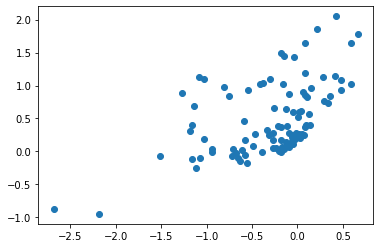

In [23]:
plt.scatter(adv_stats['min'], adv_stats['max'])

In [24]:
adventures.groupby('scenario.name').agg({'success_probability': 'mean'}).reset_index().sort_values(by='success_probability')

,scenario.name,success_probability
6,green_locked,0.182353
3,default,0.359299
1,clue,0.448179
2,clue*3,0.510711
8,yellow,0.559821
0,blessed,0.562470
7,red,0.640251
9,yellow+red,0.783714
10,yellow+red+clue,0.783750
4,geared,0.792304


In [25]:
import matplotlib

In [26]:
# plt.style.use('ggplot')
plt.style.use('default')

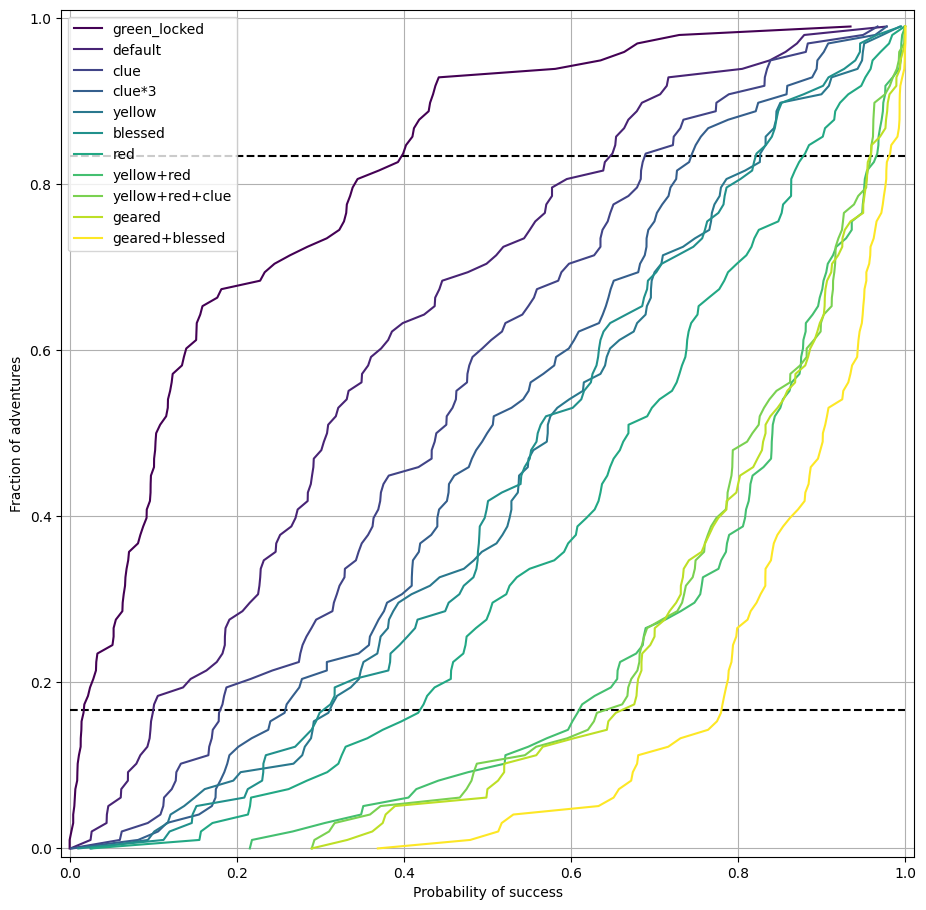

In [27]:
cmap = matplotlib.cm.get_cmap('viridis')

scenarios = adventures.groupby('scenario.name')\
    .agg({'success_probability': 'mean'}).reset_index().sort_values(by='success_probability').reset_index(drop=True)
_scale = scenarios.index.values/scenarios.index.values.max()

plt.figure(figsize=(11, 11))
for i, scn in enumerate(scenarios['scenario.name']):
    a = adventures[adventures['scenario.name']==scn]['success_probability']
    plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False), label=scn, color=cmap(_scale[i]))

plt.hlines([1/6, 5/6], 0, 1, color='k', linestyle='--')
plt.ylabel('Fraction of adventures')
plt.xlabel('Probability of success')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.grid()
plt.legend()

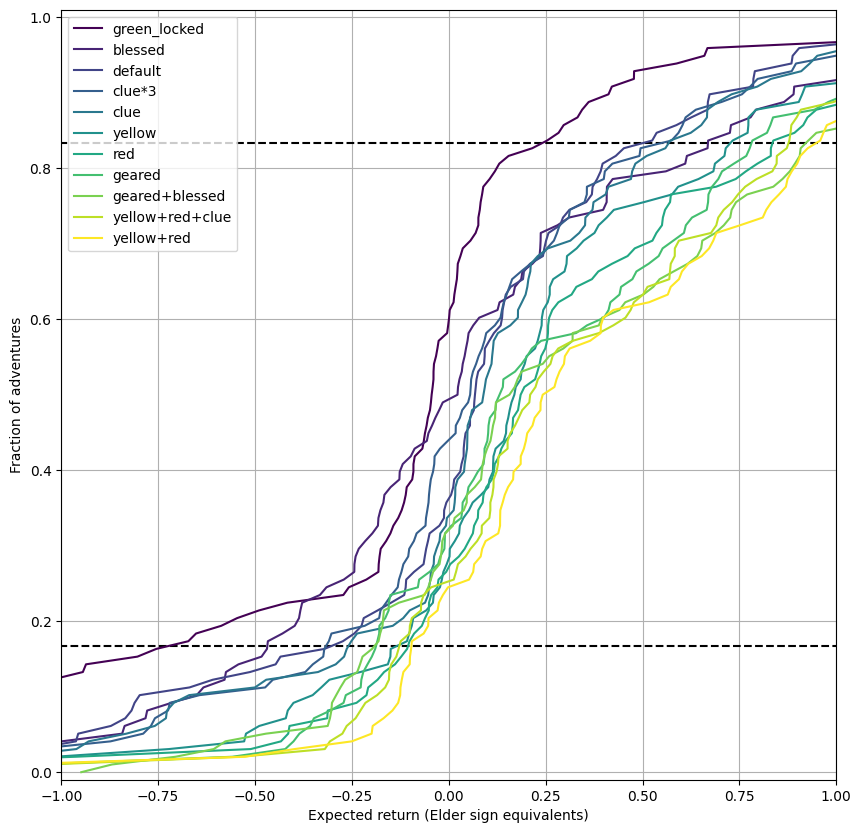

In [28]:
scenarios = adventures.groupby('scenario.name')\
    .agg({'expected_return': 'mean'}).reset_index().sort_values(by='expected_return').reset_index(drop=True)

_scale = scenarios.index.values/scenarios.index.values.max()

plt.figure(figsize=(10, 10))
for i, scn in enumerate(scenarios['scenario.name']):
    a = adventures[adventures['scenario.name']==scn]['expected_return']
    plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False), label=scn, color=cmap(_scale[i]))

_min, _max = adventures['expected_return'].min(), adventures['expected_return'].max()
plt.hlines([1/6, 5/6], _min, _max, 
           color='k', linestyle='--')
plt.ylabel('Fraction of adventures')
plt.xlabel('Expected return (Elder sign equivalents)')
# plt.xlim(_min, _max)
# plt.xlim(_min*0.5, _max*0.5)
plt.xlim(-1, 1)
plt.ylim(-0.01, 1.01)
plt.grid()    
plt.legend()

In [29]:
adventures['scenario.name'].unique()

array(['blessed', 'clue', 'clue*3', 'default', 'geared', 'geared+blessed',
       'green_locked', 'red', 'yellow', 'yellow+red', 'yellow+red+clue'],
      dtype=object)

In [30]:
adventures[
    adventures['scenario.name']=='default'
].dropna().sort_values(by='expected_return', ascending=False)[result_columns]#.head(20)

,adventure_id,scenario.name,before.value.mean,succeeded.value.mean,failed.value.mean,success_probability,expected_return
69,another_time,default,0.75,2.888889,0.465278,0.640381,1.267312
949,up_on_the_roof,default,0.75,2.975000,0.500000,0.550537,1.112579
234,great_hall_of_celeano,default,0.75,3.350000,0.687500,0.436768,1.100394
256,haunted_by_a_shadowy_figure,default,0.75,1.913242,-0.082902,0.870239,0.904221
146,don_t_fall_asleep,default,0.75,2.333333,0.687500,0.577148,0.887390
...,...,...,...,...,...,...,...
619,tempest_in_a_teapot,default,0.75,2.166667,-0.475000,0.099487,-0.962188
586,stay_away_from_the_windows,default,0.75,2.916667,-0.537500,0.061768,-1.074144
355,lights_out,default,0.75,2.250000,-0.475000,0.025024,-1.156808
795,the_hidden_temple,default,0.75,0.483333,-1.450000,0.093018,-2.020166


In [31]:
adventures[
    adventures['scenario.name']=='geared'
].dropna().sort_values(by='expected_return', ascending=False)[result_columns]#.head(20)

,adventure_id,scenario.name,before.value.mean,succeeded.value.mean,failed.value.mean,success_probability,expected_return
235,great_hall_of_celeano,geared,1.2775,3.522746,0.687500,0.883545,1.915067
719,the_elder_sign,geared,1.2775,3.198609,0.614272,0.950928,1.794290
70,another_time,geared,1.2775,3.078278,0.465278,0.919556,1.590577
785,the_hidden_passage,geared,1.2775,3.064225,0.625000,0.897583,1.536907
1016,walled_up,geared,1.2775,2.740633,0.510855,0.976807,1.411417
...,...,...,...,...,...,...,...
400,midnight_visitor,geared,1.2775,1.433809,-0.658202,0.733765,-0.400658
158,dreaming_of_a_stranger,geared,1.2775,1.729963,-0.475000,0.603394,-0.422039
323,just_sign_here,geared,1.2775,0.719398,0.687500,0.980957,-0.558709
796,the_hidden_temple,geared,1.2775,0.629342,-1.450000,0.797729,-1.068748


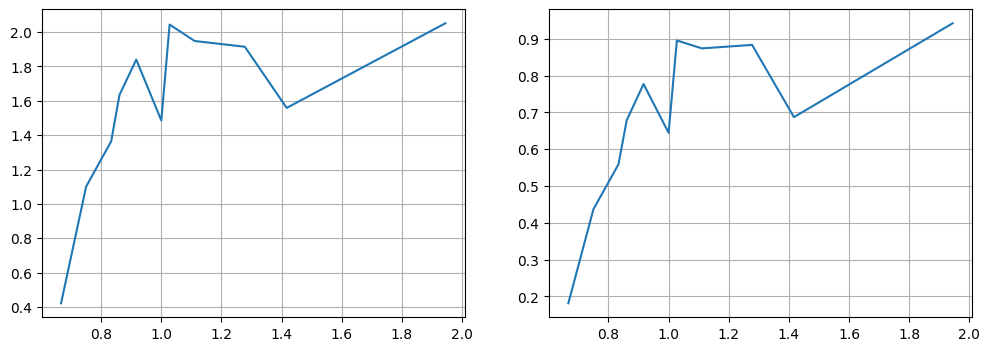

In [32]:
adv = adventures[adventures['adventure_id']=='great_hall_of_celeano'].sort_values(by='before.value.mean')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(adv['before.value.mean'], adv['expected_return'])
axes[0].grid()
axes[1].plot(adv['before.value.mean'], adv['success_probability'])
axes[1].grid()

In [33]:
adv

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
237,great_hall_of_celeano,green_locked,0.604167,3.266667,0.666667,1487,8192,0.181519,0.420793,1.087460
234,great_hall_of_celeano,default,0.687500,3.350000,0.750000,3578,8192,0.436768,1.100394,1.850394
232,great_hall_of_celeano,clue,0.687661,3.388883,0.833333,4580,8192,0.559082,1.364532,2.197866
239,great_hall_of_celeano,yellow,0.687500,3.350000,0.860833,5562,8192,0.678955,1.634385,2.495218
238,great_hall_of_celeano,red,0.687500,3.350000,0.916667,6367,8192,0.777222,1.840186,2.756853
233,great_hall_of_celeano,clue*3,0.687844,3.476475,1.000000,5281,8192,0.644653,1.485544,2.485544
240,great_hall_of_celeano,yellow+red,0.687500,3.350000,1.027500,7336,8192,0.895508,2.044290,3.071790
241,great_hall_of_celeano,yellow+red+clue,0.687500,3.401094,1.110833,7160,8192,0.874023,1.948411,3.059245
235,great_hall_of_celeano,geared,0.687500,3.522746,1.277500,7238,8192,0.883545,1.915067,3.192567
231,great_hall_of_celeano,blessed,0.687500,4.016667,1.416667,5630,8192,0.687256,1.558823,2.975489


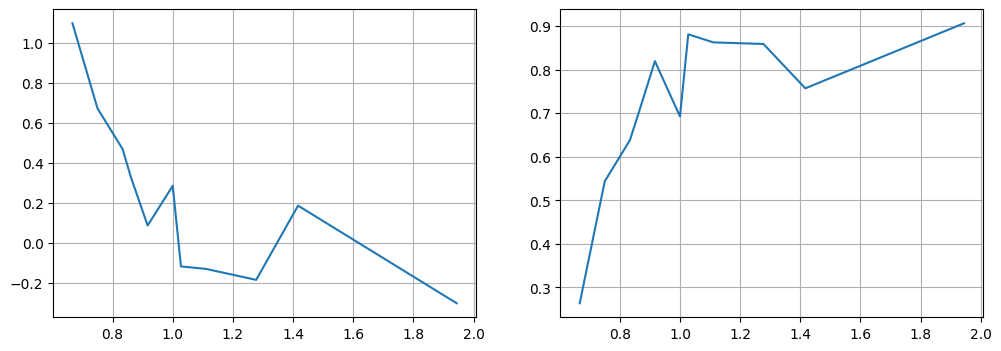

In [34]:
adv = adventures[adventures['adventure_id']=='another_dimension'].sort_values(by='before.value.mean')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(adv['before.value.mean'], adv['expected_return'])
axes[0].grid()
axes[1].plot(adv['before.value.mean'], adv['success_probability'])
axes[1].grid()

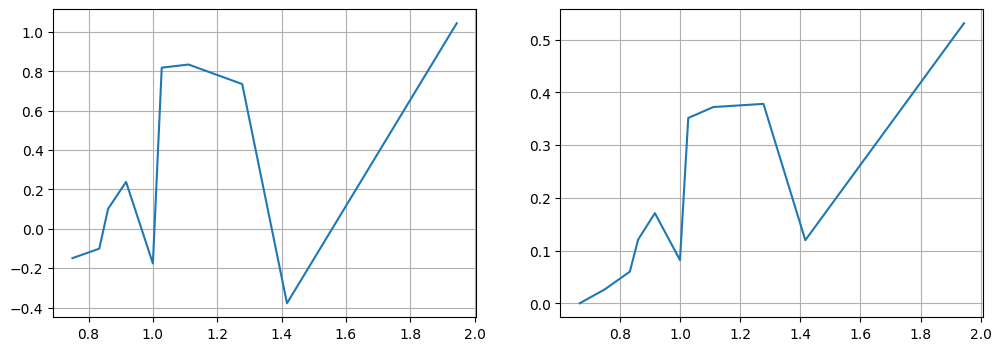

In [35]:
adv = adventures[adventures['adventure_id']=='r_lyeh'].sort_values(by='before.value.mean')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(adv['before.value.mean'], adv['expected_return'])
axes[0].grid()
axes[1].plot(adv['before.value.mean'], adv['success_probability'])
axes[1].grid()

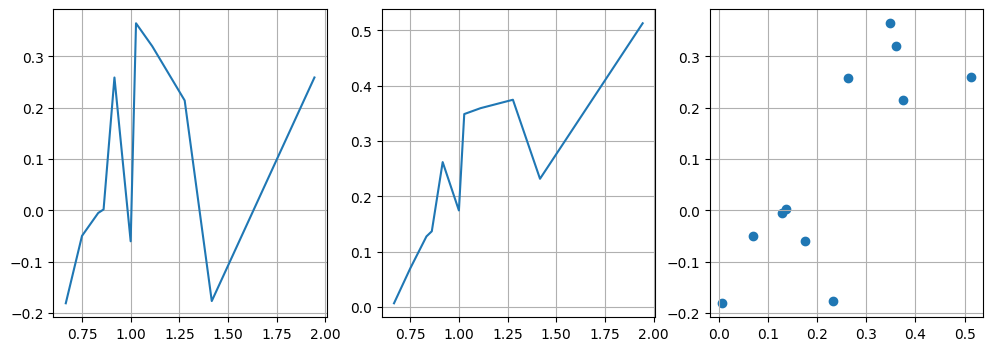

In [36]:
adv = adventures[adventures['adventure_id']=='plateau_of_leng'].sort_values(by='before.value.mean')
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(adv['before.value.mean'], adv['expected_return'])
axes[0].grid()
axes[1].plot(adv['before.value.mean'], adv['success_probability'])
axes[1].grid()
axes[2].scatter(adv['success_probability'], adv['expected_return'])
axes[2].grid()

In [37]:
adventures.sample(10).sort_values(by='success_probability')

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
336,koi_pond,green_locked,0.479167,1.833333,0.666667,582,8192,0.071045,-0.091293,0.575373
875,the_true_history,green_locked,-0.486022,2.375000,0.666667,1000,8192,0.122070,-0.803443,-0.136776
579,something_has_broken_free,red,0.687500,1.250000,0.916667,2326,8192,0.283936,-0.069453,0.847214
505,recruiting_aid,yellow+red+clue,0.687500,1.358042,1.110833,2543,8192,0.310425,-0.215181,0.895653
499,recruiting_aid,geared,0.687500,1.418235,1.277500,3189,8192,0.389282,-0.305538,0.971962
232,great_hall_of_celeano,clue,0.687661,3.388883,0.833333,4580,8192,0.559082,1.364532,2.197866
41,administration_office,yellow,0.770833,0.916667,0.860833,5203,8192,0.635132,0.002623,0.863457
462,prized_display,blessed,0.687500,1.500000,1.416667,7592,8192,0.926758,0.023824,1.440491
532,riot_in_the_streets,geared,-0.597125,2.408230,1.277500,7779,8192,0.949585,0.979215,2.256715
933,under_construction,yellow+red,-0.562183,1.053070,1.027500,7916,8192,0.966309,-0.028850,0.998650


In [38]:
adv

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
446,plateau_of_leng,green_locked,0.468427,3.016667,0.666667,56,8192,0.006836,-0.180820,0.485847
443,plateau_of_leng,default,0.521604,3.083719,0.750000,572,8192,0.069824,-0.049498,0.700502
441,plateau_of_leng,clue,0.498531,3.082831,0.833333,1046,8192,0.127686,-0.004825,0.828509
448,plateau_of_leng,yellow,0.512350,3.071145,0.860833,1122,8192,0.136963,0.001976,0.862810
447,plateau_of_leng,red,0.503153,3.070643,0.916667,2146,8192,0.261963,0.259073,1.175740
442,plateau_of_leng,clue*3,0.476606,3.130929,1.000000,1430,8192,0.174561,-0.060054,0.939946
449,plateau_of_leng,yellow+red,0.496485,3.064867,1.027500,2857,8192,0.348755,0.364721,1.392221
450,plateau_of_leng,yellow+red+clue,0.500834,3.088734,1.110833,2944,8192,0.359375,0.320027,1.430860
444,plateau_of_leng,geared,0.488117,3.167252,1.277500,3069,8192,0.374634,0.214312,1.491812
440,plateau_of_leng,blessed,0.486632,3.737375,1.416667,1899,8192,0.231812,-0.176475,1.240192


In [39]:
pd.set_option('display.max_rows', 100)
adventures.groupby('adventure_id').agg({
    'expected_return': ['min', 'mean', 'max', 'std'],
    'success_probability': ['min', 'mean', 'max', 'std']
}).reset_index().sort_values(by=[('expected_return' ,'mean')], ascending=False).reset_index(drop=True)

adventure_id expected_return                      \
                                                    min      mean       max   
0                 great_hall_of_celeano        0.420793  1.578562  2.051755   
1                          another_time        0.667523  1.481730  1.782988   
2                        the_elder_sign        0.215454  1.326543  1.862769   
3                        up_on_the_roof        0.588092  1.150889  1.638729   
4                    the_hidden_passage        0.085927  1.087174  1.641033   
5                      horrible_visions        0.412170  0.991691  1.140357   
6                gala_in_the_great_hall        0.080008  0.986505  1.195896   
7                             walled_up       -0.178627  0.948004  1.491762   
8                     don_t_fall_asleep        0.477740  0.876969  1.080015   
9                       the_boiler_room       -0.038181  0.857200  1.428400   
10                       the_dreamlands        0.478233  0.827374  0.925680   
11          haunted_by_a_shadowy_figure        0.592829  0.778448  1.019806   
12                      public_lavatory        0.283330  0.757402  1.126497   
13                        sudden_attack        0.154282  0.724013  0.966747   
14                      grazed_writings        0.360926  0.712967  0.837502   
15                              yuggoth       -0.150632  0.702872  1.444683   
16                    vital_information        0.296387  0.632072  0.766744   
17               city_of_the_great_race        0.055906  0.593316  0.899090   
18                 visiting_antiquarian        0.332176  0.591487  0.740415   
19                   the_night_watchman       -0.416539  0.590932  1.023126   
20                       the_hedge_maze        0.105334  0.562608  0.832623   
21                   blood_on_the_floor        0.082199  0.560126  0.852174   
22                     the_door_is_ajar        0.017583  0.441620  0.594105   
23                    walking_the_ledge       -0.094332  0.434089  0.874149   
24                       repugnant_tome        0.130330  0.410863  0.565162   
25                     vision_of_demise        0.036110  0.409307  0.618061   
26                            the_abyss       -0.161718  0.396271  1.020616   
27                     the_true_history       -0.803443  0.349248  0.975692   
28                 a_terrible_discovery       -0.046066  0.347214  0.601666   
29                               r_lyeh       -0.378337  0.297096  1.044735   
30                  a_peculiar_specimen        0.002403  0.294067  0.516651   
31                      hallway_on_fire        0.139541  0.279640  0.408193   
32                      rite_of_passage       -1.025241  0.270146  1.106321   
33               fragments_of_knowledge       -0.127467  0.260436  0.651445   
34                mysterious_puzzle_box        0.089858  0.254164  0.407588   
35                     when_night_falls       -0.257904  0.246382  0.652767   
36  you_become_that_which_you_fear_most        0.085354  0.234323  0.369405   
37                    another_dimension       -0.301454  0.218189  1.098999   
38                     ominous_portents       -0.546224  0.193918  0.926276   
39                    did_you_hear_that        0.050839  0.176261  0.260627   
40                          it_s_got_me        0.076284  0.173568  0.243067   
41                      the_guided_tour        0.020874  0.168981  0.269309   
42                   a_secret_gathering       -0.111071  0.151707  0.392430   
43                  forgotten_knowledge       -0.215647  0.143903  0.391984   
44                        in_the_stacks       -0.020481  0.135584  0.280561   
45                  vermin_in_the_pipes        0.012370  0.130580  0.222599   
46                  the_security_office       -0.064423  0.116790  0.243827   
47                    unnatural_habitat        0.023262  0.108329  0.202716   
48                             koi_pond       -0.091293  0.106573  0.278039  

In [40]:
adventures[adventures['adventure_id']=='please_do_not_touch_the_exhibits'].sort_values(by='success_probability')

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
457,please_do_not_touch_the_exhibits,green_locked,-2.321657,2.365881,0.666667,530,8192,0.064697,-2.685053,-2.018386
454,please_do_not_touch_the_exhibits,default,-2.711641,2.124043,0.750000,1847,8192,0.225464,-2.371369,-1.621369
452,please_do_not_touch_the_exhibits,clue,-3.262998,1.868006,0.833333,2645,8192,0.322876,-2.439654,-1.606320
459,please_do_not_touch_the_exhibits,yellow,-3.214198,2.039976,0.860833,3016,8192,0.368164,-2.140633,-1.279800
453,please_do_not_touch_the_exhibits,clue*3,-3.676480,1.702562,1.000000,3353,8192,0.409302,-2.474829,-1.474829
451,please_do_not_touch_the_exhibits,blessed,-3.313664,2.551396,1.416667,3863,8192,0.471558,-1.964617,-0.547950
458,please_do_not_touch_the_exhibits,red,-3.249080,1.960762,0.916667,4145,8192,0.505981,-1.529663,-0.612996
460,please_do_not_touch_the_exhibits,yellow+red,-3.793204,1.841080,1.027500,5367,8192,0.655151,-1.129395,-0.101895
461,please_do_not_touch_the_exhibits,yellow+red+clue,-3.998744,1.750531,1.110833,5475,8192,0.668335,-1.267136,-0.156302
455,please_do_not_touch_the_exhibits,geared,-4.184236,1.825172,1.277500,5534,8192,0.675537,-1.402158,-0.124658


In [41]:
pd.set_option('display.max_rows', 100)
adv_stats.sort_values(by='mean', ascending=False)

,adventure_id,min,mean,max,std
21,great_hall_of_celeano,0.420793,1.578562,2.051755,0.488500
6,another_time,0.667523,1.481730,1.782988,0.323301
65,the_elder_sign,0.215454,1.326543,1.862769,0.503535
86,up_on_the_roof,0.588092,1.150889,1.638729,0.321719
71,the_hidden_passage,0.085927,1.087174,1.641033,0.507711
25,horrible_visions,0.412170,0.991691,1.140357,0.203229
18,gala_in_the_great_hall,0.080008,0.986505,1.195896,0.346229
92,walled_up,-0.178627,0.948004,1.491762,0.513856
13,don_t_fall_asleep,0.477740,0.876969,1.080015,0.157659
60,the_boiler_room,-0.038181,0.857200,1.428400,0.482285


In [42]:
adventures.sort_values(by='expected_return', ascending=False)[result_columns].head(100)

,adventure_id,scenario.name,before.value.mean,succeeded.value.mean,failed.value.mean,success_probability,expected_return
236,great_hall_of_celeano,geared+blessed,1.944167,4.198653,0.687500,0.942261,2.051755
240,great_hall_of_celeano,yellow+red,1.027500,3.350000,0.687500,0.895508,2.044290
241,great_hall_of_celeano,yellow+red+clue,1.110833,3.401094,0.687500,0.874023,1.948411
235,great_hall_of_celeano,geared,1.277500,3.522746,0.687500,0.883545,1.915067
720,the_elder_sign,geared+blessed,1.944167,3.881361,0.620989,0.977173,1.862769
238,great_hall_of_celeano,red,0.916667,3.350000,0.687500,0.777222,1.840186
725,the_elder_sign,yellow+red+clue,1.110833,3.097249,0.587376,0.926392,1.801668
719,the_elder_sign,geared,1.277500,3.198609,0.614272,0.950928,1.794290
75,another_time,yellow+red,1.027500,2.888889,0.465278,0.967651,1.782988
724,the_elder_sign,yellow+red,1.027500,3.058333,0.565797,0.888916,1.753952


### Hardest and easiest

In [43]:
adventures[adventures['scenario.name']=='default'].sort_values(by='success_probability')

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
498,recruiting_aid,default,0.687500,1.333333,0.75,8,8192,0.000977,-0.061869,0.688131
355,lights_out,default,-0.475000,2.250000,0.75,205,8192,0.025024,-1.156808,-0.406808
487,r_lyeh,default,0.500000,4.333333,0.75,216,8192,0.026367,-0.148926,0.601074
377,lost_carcosa,default,0.562500,3.333333,0.75,362,8192,0.044189,-0.065058,0.684942
564,slithering_shadows,default,0.625000,1.416667,0.75,365,8192,0.044556,-0.089727,0.660273
674,the_curator,default,0.625000,2.166667,0.75,379,8192,0.046265,-0.053675,0.696325
311,it_s_quiet,default,-0.350000,2.000000,0.75,501,8192,0.061157,-0.956281,-0.206281
586,stay_away_from_the_windows,default,-0.537500,2.916667,0.75,506,8192,0.061768,-1.074144,-0.324144
641,the_abyss,default,0.562500,3.416667,0.75,571,8192,0.069702,0.011442,0.761442
443,plateau_of_leng,default,0.521604,3.083719,0.75,572,8192,0.069824,-0.049498,0.700502


### Negative reward cards

In [44]:
pd.set_option('display.max_rows', 150)
adventures[(adventures['succeeded.value.mean'] - adventures['before.value.mean']) < 0]\
    .sort_values(by='expected_return')

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value
798,the_hidden_temple,green_locked,-1.533333,0.400000,0.666667,76,8192,0.009277,-2.182064,-1.515397
792,the_hidden_temple,blessed,-1.450000,1.150000,1.416667,2371,8192,0.289429,-2.114152,-0.697485
795,the_hidden_temple,default,-1.450000,0.483333,0.750000,762,8192,0.093018,-2.020166,-1.270166
793,the_hidden_temple,clue,-1.450000,0.510759,0.833333,1498,8192,0.182861,-1.924786,-1.091453
794,the_hidden_temple,clue*3,-1.450000,0.572849,1.000000,2251,8192,0.274780,-1.894161,-0.894161
800,the_hidden_temple,yellow,-1.450000,0.483333,0.860833,2836,8192,0.346191,-1.641530,-0.780697
799,the_hidden_temple,red,-1.450000,0.483333,0.916667,3253,8192,0.397095,-1.598950,-0.682284
801,the_hidden_temple,yellow+red,-1.450000,0.483333,1.027500,5618,8192,0.685791,-1.151637,-0.124137
796,the_hidden_temple,geared,-1.450000,0.629342,1.277500,6535,8192,0.797729,-1.068748,0.208752
802,the_hidden_temple,yellow+red+clue,-1.450000,0.524139,1.110833,6339,8192,0.773804,-1.033237,0.077596


# Focusing

In [45]:
no_focus = pd.read_csv('no_focus.csv')
no_focus[result_columns]

,adventure_id,scenario.name,before.value.mean,succeeded.value.mean,failed.value.mean,success_probability,expected_return
0,a_peculiar_specimen,clue,0.833333,1.693656,0.688017,0.331299,0.187851
1,a_peculiar_specimen,clue*3,1.000000,1.755797,0.689240,0.438721,0.157160
2,a_peculiar_specimen,default,0.750000,1.666667,0.687500,0.203979,0.137230
3,a_peculiar_specimen,geared,1.458333,1.813420,0.687500,0.911865,0.255854
4,a_peculiar_specimen,green_locked,0.666667,1.583333,0.604167,0.054565,-0.009071
...,...,...,...,...,...,...,...
877,yuggoth,green_locked,0.666667,3.250000,0.479167,0.010864,-0.157397
878,yuggoth,red,1.025000,3.333333,0.562500,0.312500,0.403385
879,yuggoth,yellow,0.933333,3.333333,0.562500,0.281128,0.408125
880,yuggoth,yellow+red,1.208333,3.333333,0.562500,0.609131,1.041967


In [46]:
adventures[result_columns]

,adventure_id,scenario.name,before.value.mean,succeeded.value.mean,failed.value.mean,success_probability,expected_return
0,a_peculiar_specimen,blessed,1.416667,2.333333,0.687500,0.490723,0.078481
1,a_peculiar_specimen,clue,0.833333,1.691227,0.687933,0.342529,0.198257
2,a_peculiar_specimen,clue*3,1.000000,1.751318,0.689080,0.439941,0.156403
3,a_peculiar_specimen,default,0.750000,1.666667,0.687500,0.227051,0.159821
4,a_peculiar_specimen,geared,1.277500,1.817288,0.687500,0.891357,0.417044
...,...,...,...,...,...,...,...
1073,yuggoth,green_locked,0.666667,3.250000,0.479167,0.013306,-0.150632
1074,yuggoth,red,0.916667,3.333333,0.562500,0.427734,0.831014
1075,yuggoth,yellow,0.860833,3.333333,0.562500,0.372070,0.732611
1076,yuggoth,yellow+red,1.027500,3.333333,0.562500,0.689209,1.444683


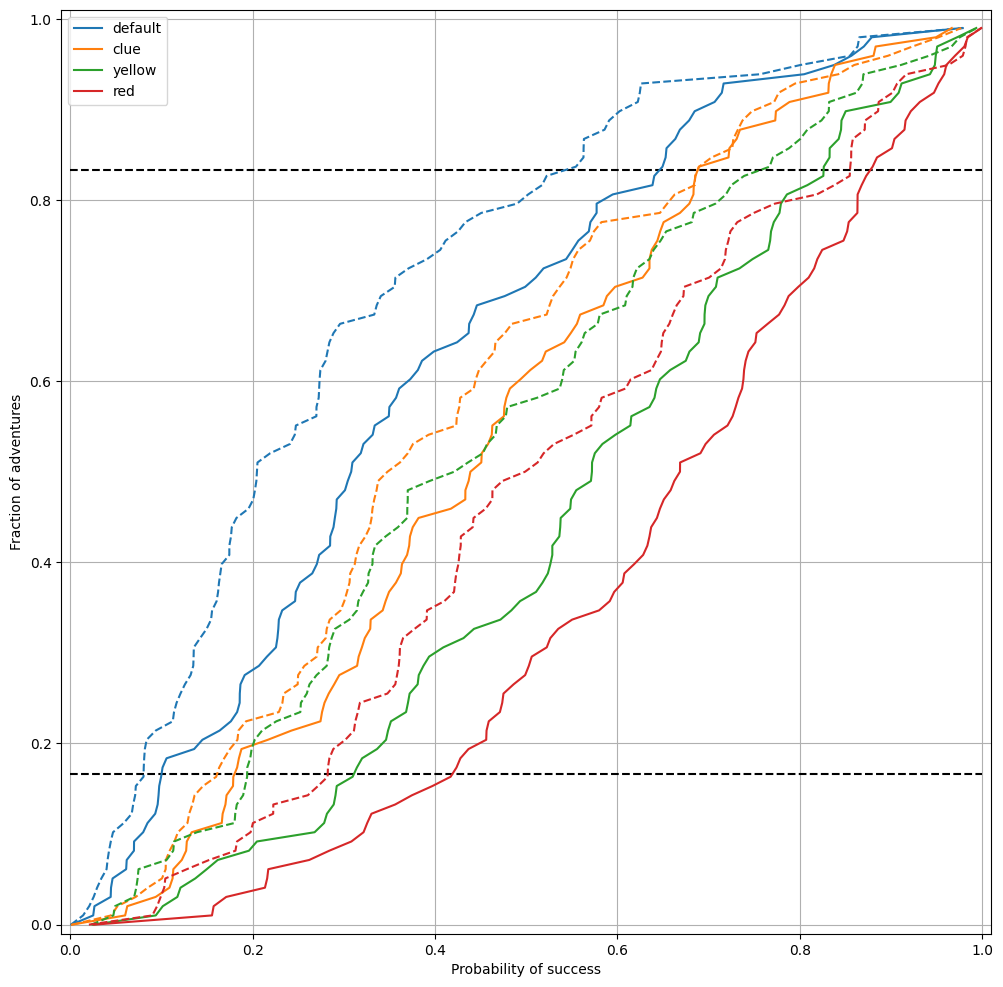

In [47]:
colour_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
focus_improvement = {}
plt.figure(figsize=(12, 12))
for i, scn in enumerate(['default','clue', 'yellow', 'red']):
    
    a_nf = no_focus[no_focus['scenario.name']==scn]['success_probability']
    plt.plot(np.sort(a_nf), np.linspace(0, 1, len(a_nf), endpoint=False), color=colour_cycle[i], linestyle='--')
    
    a = adventures[adventures['scenario.name']==scn]['success_probability']
    plt.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False), color=colour_cycle[i], label=scn)
    
    focus_improvement[scn] = np.sort(a) - np.sort(a_nf)

plt.hlines([1/6, 5/6], 0, 1, color='k', linestyle='--')
plt.ylabel('Fraction of adventures')
plt.xlabel('Probability of success')
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.grid()    
plt.legend()

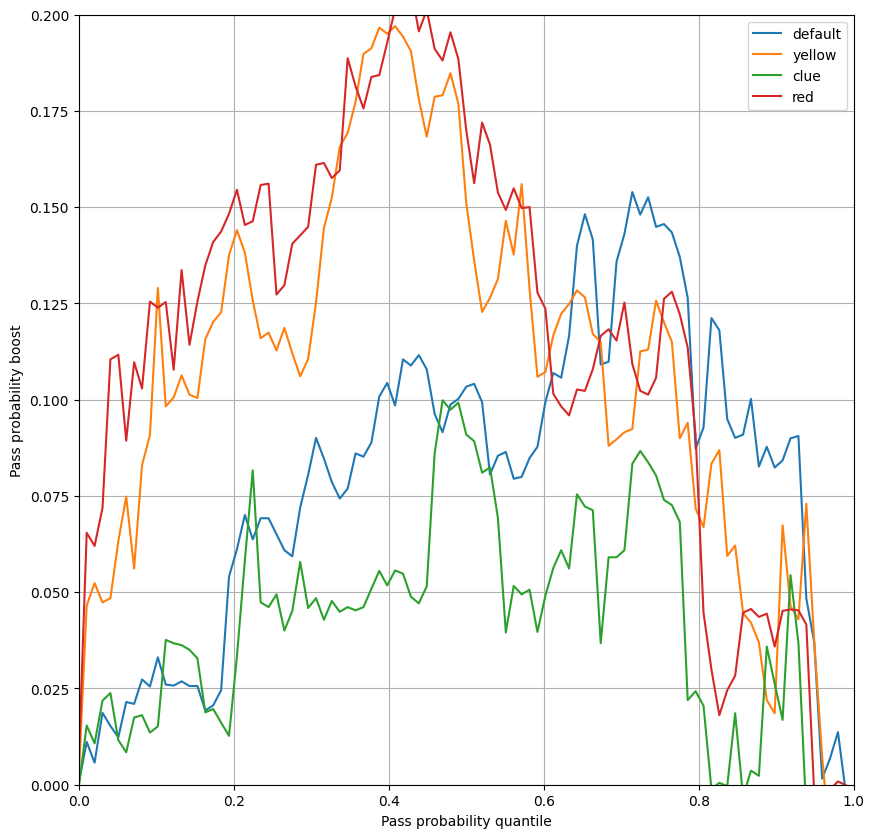

In [48]:
plt.figure(figsize=(10, 10))

for k in ['default', 'yellow', 'clue', 'red']:
    a = focus_improvement[k]
    plt.plot(np.linspace(0, 1, len(a), endpoint=False), a, label=k)

plt.grid()
plt.ylim(0, 0.2)
plt.xlim(0, 1)
plt.legend()
plt.ylabel('Pass probability boost')
plt.xlabel('Pass probability quantile')
plt.show()

# Card difficulty cheatsheet

In [49]:
adventure_details = pd.read_csv('card_details.csv')

In [50]:
adventure_num_dice = adventure_details.groupby('adventure_id').apply(
    lambda frame: frame['value'].fillna(0).sum() / 3 + len(frame[frame['value'].isnull()])
).to_frame(name='min_green_dice_to_complete').reset_index()
adventure_num_dice.sample(5)

,adventure_id,min_green_dice_to_complete
94,when_night_falls,4.000000
34,lost_carcosa,4.666667
47,repugnant_tome,3.000000
8,blood_on_the_floor,3.666667
74,the_loading_dock,3.000000


In [51]:
task_num_dice = adventure_details.groupby(['adventure_id', 'task']).apply(
    lambda frame: frame['value'].fillna(0).sum() / 3 + len(frame[frame['value'].isnull()])
).to_frame(name='min_green_dice_to_complete').reset_index()
task_num_dice

,adventure_id,task,min_green_dice_to_complete
0,a_peculiar_specimen,0,1.000000
1,a_peculiar_specimen,1,2.000000
2,a_peculiar_specimen,2,1.000000
3,a_secret_gathering,0,2.000000
4,a_secret_gathering,1,2.000000
...,...,...,...
206,wicked_old_man,0,2.333333
207,wicked_old_man,1,2.000000
208,you_become_that_which_you_fear_most,1,3.000000
209,yuggoth,0,2.000000


In [52]:
adventure_max_task_dice = task_num_dice.groupby('adventure_id').agg({
    'min_green_dice_to_complete': 'max'
}).reset_index()
adventure_max_task_dice

,adventure_id,min_green_dice_to_complete
0,a_peculiar_specimen,2.000000
1,a_secret_gathering,2.000000
2,a_terrible_discovery,2.000000
3,administration_office,3.000000
4,ancient_relics,2.000000
5,another_dimension,2.000000
6,another_time,2.000000
7,balancing_mind_and_body,2.000000
8,blood_on_the_floor,2.000000
9,bloody_footprints,2.000000


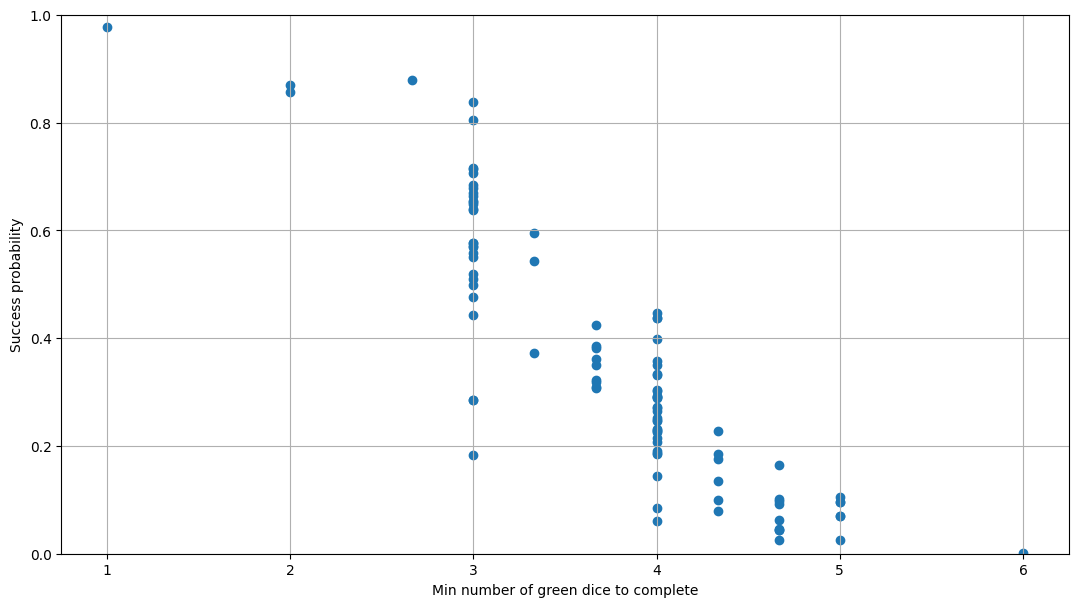

In [120]:
num_dice_analysis = adventures.merge(adventure_num_dice)
_df = num_dice_analysis[num_dice_analysis['scenario.name']=='default']

plt.figure(figsize=(13, 7))
plt.scatter(_df['min_green_dice_to_complete'], _df['success_probability'])
plt.ylim(0, 1)
plt.grid()
plt.ylabel('Success probability')
plt.xlabel('Min number of green dice to complete')
plt.show()

In [121]:
_df[_df['min_green_dice_to_complete']==3].sort_values(by='success_probability')[['adventure_id', 'success_probability']]

,adventure_id,success_probability
575,something_has_broken_free,0.182861
1059,you_become_that_which_you_fear_most,0.284790
432,ominous_portents,0.285034
476,public_lavatory,0.442383
520,repugnant_tome,0.476318
938,unnatural_habitat,0.498779
751,the_guided_tour,0.510376
817,the_loading_dock,0.518921
949,up_on_the_roof,0.550537
993,vital_information,0.557129


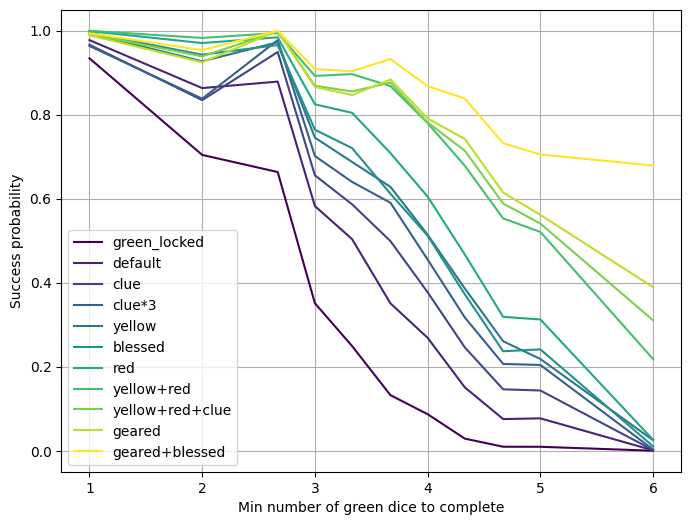

In [55]:
num_dice_analysis['min_green_dice_to_complete'] = num_dice_analysis['min_green_dice_to_complete'].round(2)
_df = num_dice_analysis\
    .groupby(['min_green_dice_to_complete', 'scenario.name'])\
    .agg({'success_probability': 'mean'})\
    .reset_index()

scenarios = _df.groupby('scenario.name')\
    .agg({'success_probability': 'mean'}).reset_index().sort_values(by='success_probability')\
    .reset_index(drop=True)

_scale = scenarios.index.values/scenarios.index.values.max()

plt.figure(figsize=(8, 6))
for i, scn in enumerate(scenarios['scenario.name']):
    a = _df[_df['scenario.name']==scn]
    plt.plot(a['min_green_dice_to_complete'], a['success_probability'], label=scn, color=cmap(_scale[i]))
    
plt.grid()
plt.legend()
plt.ylabel('Success probability')
plt.xlabel('Min number of green dice to complete')
plt.show()

In [56]:
num_dice_analysis['min_green_dice_to_complete_int'] = num_dice_analysis['min_green_dice_to_complete'].astype(int)

In [57]:
_df = num_dice_analysis\
    .groupby(['min_green_dice_to_complete_int', 'scenario.name'])\
    .agg({'success_probability': 'mean'})\
    .reset_index()

In [58]:
_df.pivot(index='scenario.name', columns='min_green_dice_to_complete_int').sort_values(by=[('success_probability', 4)])

success_probability                      \
min_green_dice_to_complete_int                   1         2         3   
scenario.name                                                            
green_locked                              0.934326  0.690715  0.294177   
default                                   0.977661  0.868571  0.524481   
clue                                      0.966675  0.872965  0.615289   
clue*3                                    0.963745  0.884644  0.671967   
blessed                                   0.994873  0.950562  0.726703   
yellow                                    0.993530  0.942301  0.714682   
red                                       0.999023  0.975138  0.797156   
yellow+red                                0.999878  0.986735  0.887296   
yellow+red+clue                           0.992065  0.958862  0.869678   
geared                                    0.989136  0.949748  0.868750   
geared+blessed                            0.993896  0.969157  0.913712   

                                                              
min_green_dice_to_complete_int         4         5         6  
scenario.name                                                 
green_locked                    0.064697  0.009379  0.000000  
default                         0.216709  0.077067  0.000977  
clue                            0.316222  0.143392  0.001587  
clue*3                          0.389898  0.204183  0.003052  
blessed                         0.441469  0.241333  0.010376  
yellow                          0.449346  0.218404  0.025024  
red                             0.532614  0.312520  0.026001  
yellow+red                      0.723594  0.520833  0.218140  
yellow+red+clue                 0.736084  0.540894  0.310425  
geared                          0.751034  0.561584  0.389282  
geared+blessed                  0.838192  0.705322  0.678955

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [60]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im #, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) < threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

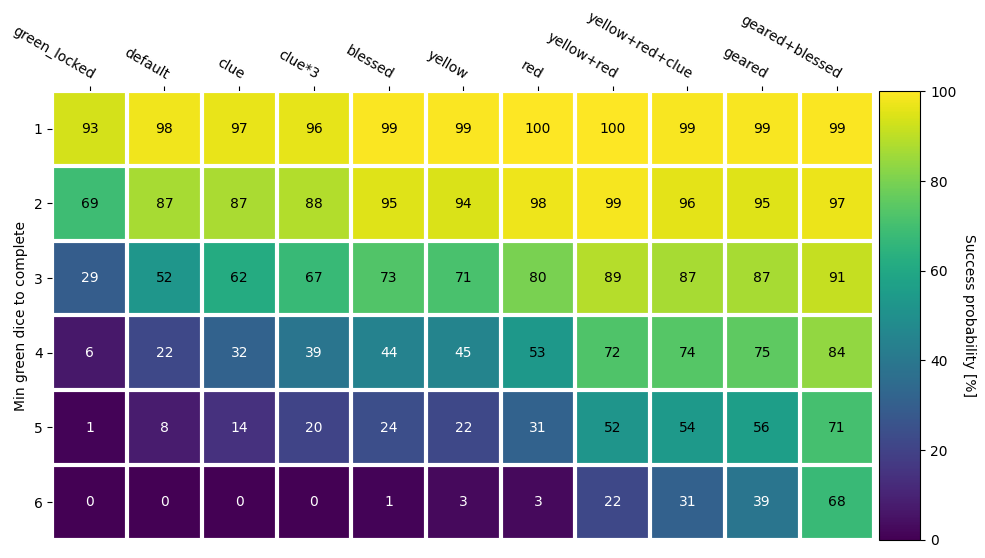

In [61]:
_df = num_dice_analysis\
    .groupby(['min_green_dice_to_complete_int', 'scenario.name'])\
    .agg({'success_probability': 'mean'})\
    .reset_index()

Z = _df.pivot(index='scenario.name', columns='min_green_dice_to_complete_int')\
    .sort_values(by=[('success_probability', 4)])

data = Z.values.T*100


fig, ax = plt.subplots(figsize=(10, 7))

im = heatmap(data, range(1, 7), Z.index, ax=ax,
                   cmap="viridis", cbarlabel="Probability of success [%]", vmin=0, vmax=100)
texts = annotate_heatmap(im, valfmt="{x:.0f}")

ax.set_ylabel('Min green dice to complete')

    
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.set_ylabel('Success probability [%]', rotation=-90, va="bottom")
        
fig.tight_layout()
plt.show()

### Fit a simple heuristic

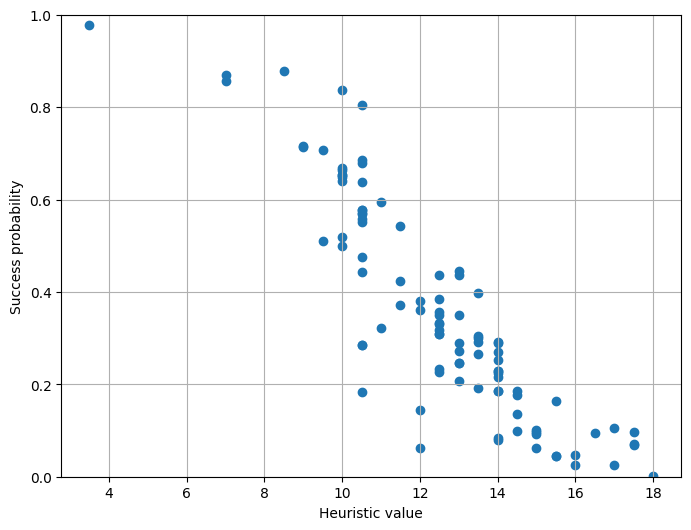

In [62]:
adventure_details['_heuristic'] = (
    adventure_details['value'].fillna(0)
    + (adventure_details['symbol'] != 'Investigation').astype(int) * 3.5
)
heuristic_analysis = adventure_details.groupby('adventure_id').agg({'_heuristic': 'sum'}).reset_index()
heuristic_analysis = adventures.merge(heuristic_analysis)
_df = heuristic_analysis[heuristic_analysis['scenario.name']=='default']

plt.figure(figsize=(8, 6))
plt.scatter(_df['_heuristic'], _df['success_probability'])
plt.ylim(0, 1)
plt.grid()
plt.ylabel('Success probability')
plt.xlabel('Heuristic value')
plt.show()

In [63]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

SpearmanrResult(correlation=-0.8955434319390143, pvalue=1.572660709243085e-35)


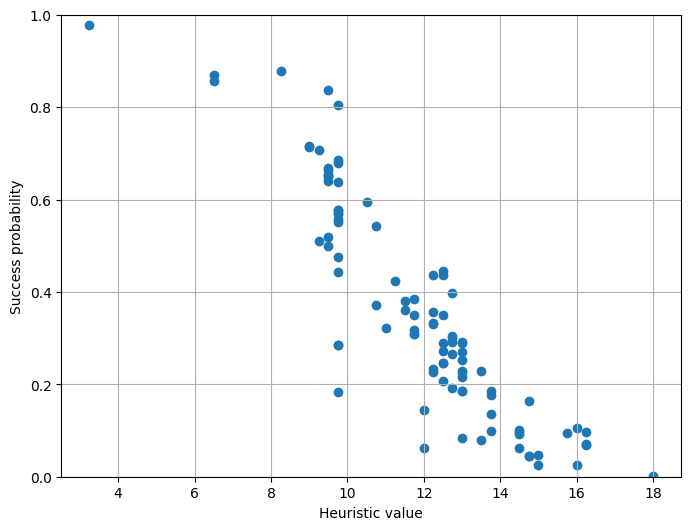

In [64]:
adventure_details['_count'] = 1
adventure_details['_heuristic'] = (
    adventure_details['value'].fillna(0)
    + (adventure_details['symbol'] != 'Investigation').astype(int) * 3.25
)
adventure_details['_is_symbol'] = (adventure_details['symbol'] != 'Investigation').astype(int) 
adventure_details['_investigations'] = adventure_details['value'].fillna(0)
heuristic_analysis = adventure_details.groupby('adventure_id').agg({
    '_heuristic': 'sum',
    '_is_symbol': 'sum',
    '_investigations': 'sum',
}).reset_index()
heuristic_analysis = adventures.merge(heuristic_analysis)
_df = heuristic_analysis[heuristic_analysis['scenario.name']=='default']

# Add most difficult task score
task_heuristic = adventure_details.groupby(['adventure_id', 'task']).agg({
    '_heuristic': 'sum', '_count': 'sum'}).reset_index()
adventure_max_heuristic = task_heuristic.groupby('adventure_id').agg({
    '_heuristic': 'max', '_count': 'max'
}).reset_index().rename(columns={'_heuristic': 'max_task_heuristic'})
_df = _df.merge(adventure_max_heuristic)

x = _df['_heuristic']+0.0*_df['max_task_heuristic']
print(spearmanr(x, _df['success_probability']))

plt.figure(figsize=(8, 6))
plt.scatter(x, _df['success_probability'])
plt.ylim(0, 1)
plt.grid()
plt.ylabel('Success probability')
plt.xlabel('Heuristic value')
plt.show()

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [66]:
lr = LinearRegression()
X = ((_df['_investigations'] / 3) + _df['_is_symbol']).values.reshape(-1, 1)
y = _df['success_probability']
lr.fit(X, y)
y_pred = lr.predict(X)
metrics.mean_absolute_error(y, y_pred), lr.coef_, (lr.coef_*1/lr.coef_[0]).round(2)

(0.08072174581656104, array([-0.2727345]), array([1.]))

In [67]:
lr = LinearRegression()
X = _df[[ '_investigations', '_is_symbol']]
# X = x.values.reshape(-1, 1)
y = _df['success_probability']
lr.fit(X, y)
y_pred = lr.predict(X)
metrics.mean_absolute_error(y, y_pred), lr.coef_, (lr.coef_*1/lr.coef_[0]).round(2)

(0.08025244303839167, array([-0.08821734, -0.28543297]), array([1.  , 3.24]))

In [68]:
lr = LinearRegression()
X = _df[[ '_investigations', '_is_symbol', '_count']]
# X = x.values.reshape(-1, 1)
y = _df['success_probability']
lr.fit(X, y)
y_pred = lr.predict(X)
metrics.mean_absolute_error(y, y_pred), lr.coef_, (lr.coef_*1/lr.coef_[0]).round(2)

(0.07772911784738246,
 array([-0.08778504, -0.27238148, -0.03544241]),
 array([1. , 3.1, 0.4]))

In [69]:
lr = LinearRegression()
X = _df[[ '_investigations', '_is_symbol', '_count']]
# X = x.values.reshape(-1, 1)
y = _df['success_probability']
lr.fit(X, y)
y_pred = lr.predict(X)
metrics.mean_absolute_error(y, y_pred), lr.coef_, (lr.coef_*1/lr.coef_[0]).round(2)

(0.07772911784738246,
 array([-0.08778504, -0.27238148, -0.03544241]),
 array([1. , 3.1, 0.4]))

In [70]:
_df

,adventure_id,scenario.name,failed.value.mean,succeeded.value.mean,before.value.mean,succeeded,count,success_probability,expected_return,expected_value,_heuristic,_is_symbol,_investigations,max_task_heuristic,_count
0,a_peculiar_specimen,default,0.687500,1.666667,0.75,1860,8192,0.227051,0.159821,0.909821,12.25,1,9.0,6.00,1
1,a_secret_gathering,default,0.544934,1.639580,0.75,2019,8192,0.246460,0.064720,0.814720,12.50,2,6.0,6.50,2
2,a_terrible_discovery,default,0.565284,1.875000,0.75,2467,8192,0.301147,0.209702,0.959702,12.75,3,3.0,6.50,2
3,administration_office,default,0.770833,0.916667,0.75,1903,8192,0.232300,0.054710,0.804710,12.25,1,9.0,9.00,1
4,ancient_relics,default,0.598608,1.224420,0.75,2866,8192,0.349854,0.067551,0.817551,12.50,2,6.0,6.25,2
5,another_dimension,default,2.250000,0.729167,0.75,4454,8192,0.543701,0.673121,1.423121,10.75,3,1.0,6.50,2
6,another_time,default,0.465278,2.888889,0.75,5246,8192,0.640381,1.267312,2.017312,9.50,2,3.0,6.50,2
7,balancing_mind_and_body,default,0.589671,1.383523,0.75,2393,8192,0.292114,0.071566,0.821566,13.00,4,0.0,6.50,2
8,blood_on_the_floor,default,0.625000,2.166667,0.75,2954,8192,0.360596,0.430918,1.180918,11.50,2,5.0,6.50,2
9,bloody_footprints,default,0.579113,1.742582,0.75,792,8192,0.096680,-0.058403,0.691597,16.25,5,0.0,6.50,2


# Symbol concentration

In [71]:
sym = [
    ('S', 97.8, 1),
    
    ('SS', 80.4, 2),
    ('S/S', 85.0, 2),
    
    ('SSS', 28.1, 3),
    ('SS/S', 57.6, 3),
    ('S/S/S', 55.7, 3),
    
    ('SSSS', 2.9, 4),
    ('SSS/S', 12.4, 4),
    ('SS/SS', 14.1, 4),
    ('SS/S/S', 28.0, 4),
    ('S/S/S/S', 23.3, 4),
    
    ('3', 99.9, 1),
    ('4', 99.2, 1),
    ('5', 97.3, 1),
    
    ('S3', 90.2, 2),
    ('6', 92.4, 2),
    ('7', 79.8, 2),
    
    ('SS3', 50.2, 3),
    ('S6', 62.1, 3),
    ('9', 46.0, 3),
    ('10', 25.3, 3),
    
    ('SSS3', 9.0, 4),
    ('SS6', 16.5, 4),
    ('S9', 14.4, 4),
    ('12', 6.3, 4)
    
]
sym = pd.DataFrame(sym, columns=('tasks', 'success_probability', 'num_symbols'))
sym.sort_values(by='success_probability', ascending=False)

,tasks,success_probability,num_symbols
11,3,99.9,1
12,4,99.2,1
0,S,97.8,1
13,5,97.3,1
15,6,92.4,2
14,S3,90.2,2
2,S/S,85.0,2
1,SS,80.4,2
16,7,79.8,2
18,S6,62.1,3


In [72]:
sym_dict = {row['tasks']: row['success_probability'] for i, row in sym.iterrows()}

### More concentrated tasks are harder

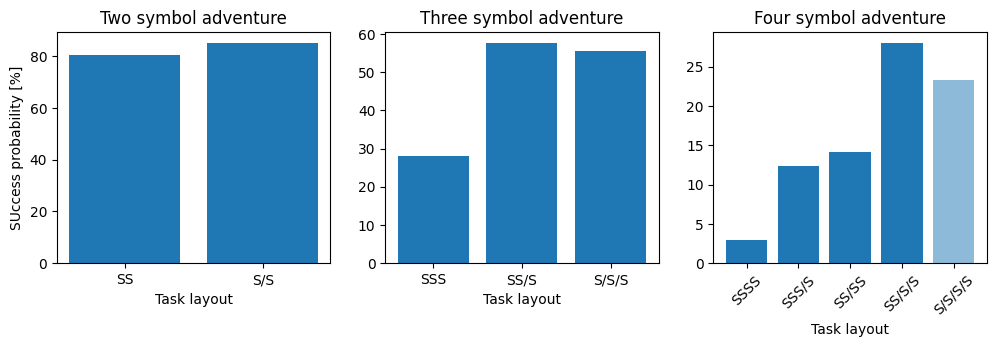

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

two_symbol = ['SS', 'S/S']
axes[0].set_title('Two symbol adventure')
axes[0].bar(range(2), [sym_dict[s] for s in two_symbol])
axes[0].set_xticks(range(len(two_symbol)))
axes[0].set_xticklabels(two_symbol)

three_symbol = ['SSS', 'SS/S', 'S/S/S']
axes[1].set_title('Three symbol adventure')
axes[1].bar(range(3), [sym_dict[s] for s in three_symbol])
axes[1].set_xticks(range(len(three_symbol)))
axes[1].set_xticklabels(three_symbol)

four_symbol = ['SSSS', 'SSS/S', 'SS/SS', 'SS/S/S', 'S/S/S/S']
axes[2].set_title('Four symbol adventure')
axes[2].bar(range(4), [sym_dict[s] for s in four_symbol[:-1]])
axes[2].bar([4], [sym_dict[s] for s in four_symbol[-1:]], alpha=0.5, color=colour_cycle[0])
axes[2].set_xticks(range(len(four_symbol)))
axes[2].set_xticklabels(four_symbol, rotation='45')

axes[0].set_ylabel('SUccess probability [%]')
for i in range(3):
    axes[i].set_xlabel('Task layout')


### Investigations are easier than symbols, but a mix is better still

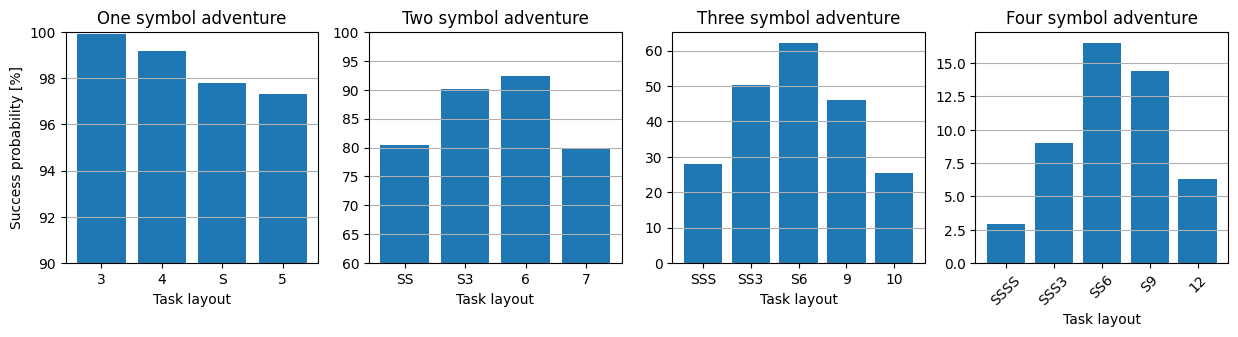

In [74]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

one_symbol = ['3', '4', 'S', '5']
axes[0].set_title('One symbol adventure')
axes[0].bar(range(len(one_symbol)), [sym_dict[s] for s in one_symbol])
axes[0].set_xticks(range(len(one_symbol)))
axes[0].set_xticklabels(one_symbol)
axes[0].set_ylim(90, 100)

two_symbol = ['SS', 'S3', '6', '7']
axes[1].set_title('Two symbol adventure')
axes[1].bar(range(len(two_symbol)), [sym_dict[s] for s in two_symbol])
axes[1].set_xticks(range(len(two_symbol)))
axes[1].set_xticklabels(two_symbol)
axes[1].set_ylim(60, 100)


three_symbol = ['SSS', 'SS3', 'S6', '9', '10']
axes[2].set_title('Three symbol adventure')
axes[2].bar(range(len(three_symbol)), [sym_dict[s] for s in three_symbol])
# axes[2].bar(range(len(three_symbol[:-1])), [sym_dict[s] for s in three_symbol[:-1]])
# axes[2].bar([4], [sym_dict[s] for s in three_symbol[-1:]], alpha=0.5, color=colour_cycle[0])
axes[2].set_xticks(range(len(three_symbol)))
axes[2].set_xticklabels(three_symbol)

four_symbol = ['SSSS', 'SSS3', 'SS6', 'S9', '12']
axes[3].set_title('Four symbol adventure')
axes[3].bar(range(len(four_symbol)), [sym_dict[s] for s in four_symbol])
# axes[3].bar([4], [sym_dict[s] for s in four_symbol[-1:]], alpha=0.5, color=colour_cycle[0])
axes[3].set_xticks(range(len(four_symbol)))
axes[3].set_xticklabels(four_symbol, rotation='45')

axes[0].set_ylabel('Success probability [%]')
for i in range(4):
    axes[i].set_xlabel('Task layout')
    axes[i].grid(axis='y')

### Ordering makes relatively little difference

In [75]:
ordering = {
    'SS/S': (48.1, sym_dict['SS/S']),
    'SSS/S':(9.4, sym_dict['SSS/S']),
    'SS/S/S':(18.2, sym_dict['SS/S/S']),
}
ordering

{'SS/S': (48.1, 57.6), 'SSS/S': (9.4, 12.4), 'SS/S/S': (18.2, 28.0)}

In [76]:
48.1/57.6, 18.2/ 28.0

(0.8350694444444444, 0.65)

Text(0, 0.5, 'Success probability [%]')

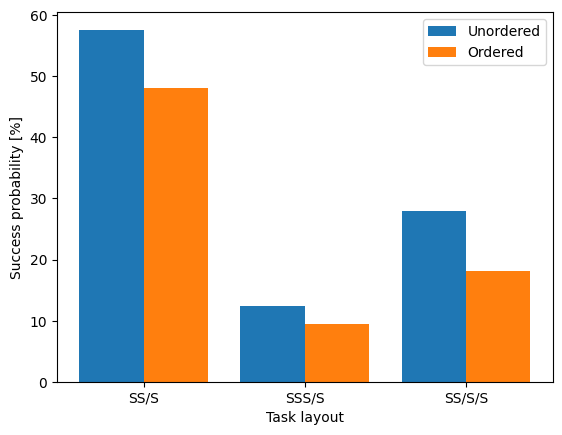

In [77]:
fig, axes = plt.subplots(1, 1)
axes.bar(
    np.arange(3)-0.2,
    [v[1] for k, v in ordering.items()],
    width=0.4,
    label='Unordered'
)
axes.bar(
    np.arange(3)+0.2,
    [v[0] for k, v in ordering.items()],
    width=0.4,
    label='Ordered'
)
axes.set_xticks(np.arange(3))
axes.set_xticklabels([k for k, v in ordering.items()])
axes.legend()
axes.set_xlabel('Task layout')
axes.set_ylabel('Success probability [%]')

# Tier list

In [78]:
tier_cols = ['adventure_id', 'success_probability', 'expected_return']

In [96]:
select_card = 'great_hall_of_celeano'

In [98]:
adv_stats.sort_values(by=)

,adventure_id,min,mean,max,std
0,a_peculiar_specimen,0.002403,0.294067,0.516651,0.178635
1,a_secret_gathering,-0.111071,0.151707,0.392430,0.150265
2,a_terrible_discovery,-0.046066,0.347214,0.601666,0.180020
3,administration_office,-0.240476,-0.098237,0.054710,0.108907
4,ancient_relics,-0.057213,0.076088,0.153426,0.066718
5,another_dimension,-0.301454,0.218189,1.098999,0.417963
6,another_time,0.667523,1.481730,1.782988,0.323301
7,balancing_mind_and_body,-0.061480,0.046809,0.221579,0.105380
8,blood_on_the_floor,0.082199,0.560126,0.852174,0.209852
9,bloody_footprints,-0.315653,0.014089,0.242382,0.170800


In [97]:
adventures[
    adventures['adventure_id']==select_card
].sort_values(by='success_probability')[tier_cols+['scenario.name']]

,adventure_id,success_probability,expected_return,scenario.name
237,great_hall_of_celeano,0.181519,0.420793,green_locked
234,great_hall_of_celeano,0.436768,1.100394,default
232,great_hall_of_celeano,0.559082,1.364532,clue
233,great_hall_of_celeano,0.644653,1.485544,clue*3
239,great_hall_of_celeano,0.678955,1.634385,yellow
231,great_hall_of_celeano,0.687256,1.558823,blessed
238,great_hall_of_celeano,0.777222,1.840186,red
241,great_hall_of_celeano,0.874023,1.948411,yellow+red+clue
235,great_hall_of_celeano,0.883545,1.915067,geared
240,great_hall_of_celeano,0.895508,2.044290,yellow+red


In [88]:
_df = adventures[
    adventures['scenario.name']==select_card
].sort_values(by='expected_return', ascending=False).head(5)[tier_cols]
_df

,adventure_id,success_probability,expected_return
69,another_time,0.640381,1.267312
949,up_on_the_roof,0.550537,1.112579
234,great_hall_of_celeano,0.436768,1.100394
256,haunted_by_a_shadowy_figure,0.870239,0.904221
146,don_t_fall_asleep,0.577148,0.887390


In [87]:
_df = adventures[
    adventures['scenario.name']=='yellow+red'
].sort_values(by='expected_return', ascending=False).head(5)[tier_cols]
_df

,adventure_id,success_probability,expected_return
240,great_hall_of_celeano,0.895508,2.044290
75,another_time,0.967651,1.782988
724,the_elder_sign,0.888916,1.753952
955,up_on_the_roof,0.875244,1.638729
790,the_hidden_passage,0.877441,1.608303


In [89]:
_df = adventures[
    adventures['scenario.name']=='red'
].sort_values(by='expected_return', ascending=False).head(5)[tier_cols]
_df

,adventure_id,success_probability,expected_return
238,great_hall_of_celeano,0.777222,1.840186
73,another_time,0.903809,1.739092
953,up_on_the_roof,0.809692,1.587322
722,the_elder_sign,0.729614,1.468500
788,the_hidden_passage,0.691040,1.291967


In [91]:
_df = adventures[
    adventures['scenario.name']=='yellow'
].sort_values(by='expected_return', ascending=False).head(5)[tier_cols]
_df

,adventure_id,success_probability,expected_return
74,another_time,0.842651,1.646704
239,great_hall_of_celeano,0.678955,1.634385
954,up_on_the_roof,0.690674,1.348584
723,the_elder_sign,0.642578,1.309272
206,gala_in_the_great_hall,0.972534,1.171980


In [90]:
_df = adventures[
    adventures['scenario.name']=='clue'
].sort_values(by='expected_return', ascending=False).head(5)[tier_cols]
_df

,adventure_id,success_probability,expected_return
232,great_hall_of_celeano,0.559082,1.364532
67,another_time,0.685669,1.319466
716,the_elder_sign,0.548828,1.123069
276,horrible_visions,0.838501,1.032786
199,gala_in_the_great_hall,0.949341,0.950836


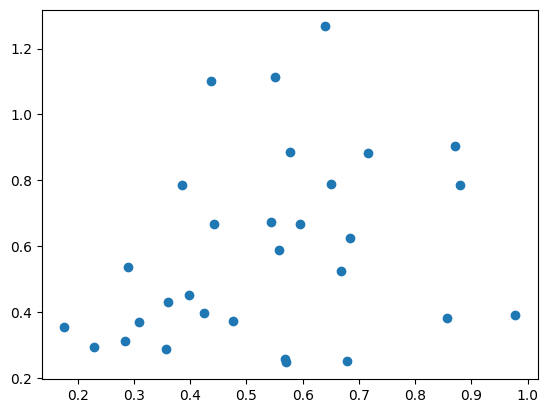

In [81]:
plt.scatter(_df['success_probability'], _df['expected_return'])

In [82]:
df[(df['adventure_id']=='up_on_the_roof')&(df['after'])][['attempt_id', 'succeeded', 'num_monsters', 'monster.value']]

,attempt_id,succeeded,num_monsters,monster.value
1,38e9f35d120b40c99f3b569d6b1cc962,True,1.5,-0.25
3,e726c5042c984e07a205928223cd4b87,False,0.5,-0.25
5,36660a116dd74d4484c44add6b563fb5,True,1.5,-0.25
7,29c9cbad112340e3b89f50dc9f783c48,True,1.5,-0.25
9,12a088d555c7468eadf6692509faa899,True,1.5,-0.25
...,...,...,...,...
180215,3020991b82a748d68316fcd7102a4a81,False,0.5,-0.25
180217,3a26259215e44ce58bf52af25c797955,False,0.5,-0.25
180219,c38c5f6660814ddea506039fd7975eed,True,1.5,-0.25
180221,3ed8be77a48f4373a7fcc93960af8b7b,False,0.5,-0.25


In [83]:
df[(df['adventure_id']=='another_time')&(df['after'])][['attempt_id', 'succeeded', 'clock.hour', 'clock.turn.value']]

,attempt_id,succeeded,clock.hour,clock.turn.value
1,8138d1f7961d44e483a1058fe9f31b0a,False,4,-0.166667
3,1da15353b1384a699e3e6a7e4c08e5d3,False,4,-0.166667
5,21d6a254c32249108f4a41bc5b4d66a0,True,2,-0.166667
7,69a61477af4941048123494f8ea153ef,True,2,-0.166667
9,333005163f104b5d8ba349829ac1010e,False,4,-0.166667
...,...,...,...,...
180215,029d45a29f844394ad6a7f6a3681c95a,True,2,-0.166667
180217,703db5f4bd3845a69efa94542060c5f5,True,2,-0.166667
180219,3ca62a50cc784f6e9d5ff7cd378dade7,True,2,-0.166667
180221,792a1f46c6624ce495510ea7485953ff,True,2,-0.166667


In [84]:
adventures[
    adventures['scenario.name']=='default'
].sort_values(by='expected_return').head(10)[tier_cols]

,adventure_id,success_probability,expected_return
454,please_do_not_touch_the_exhibits,0.225464,-2.371369
795,the_hidden_temple,0.093018,-2.020166
355,lights_out,0.025024,-1.156808
586,stay_away_from_the_windows,0.061768,-1.074144
619,tempest_in_a_teapot,0.099487,-0.962188
311,it_s_quiet,0.061157,-0.956281
597,strange_robberies,0.135742,-0.872070
157,dreaming_of_a_stranger,0.185791,-0.834839
861,the_storage_closet,0.206787,-0.818716
399,midnight_visitor,0.290039,-0.810849


In [100]:
selected_scenarios = ['default', 'clue', 'yellow', 'red', 'yellow+red']

In [104]:
adv_stats = adventures[adventures['scenario.name'].isin(selected_scenarios)].groupby('adventure_id').agg({
    'expected_return': ['min', 'mean', 'max', 'std'],
    'success_probability': ['min', 'mean', 'max', 'std']
}).reset_index()
# adv_stats.columns = ['adventure_id' ,'min', 'mean', 'max', 'std']
adv_stats.sort_values(by=[('expected_return', 'mean')], ascending=False)

adventure_id expected_return                      \
                                                    min      mean       max   
21                great_hall_of_celeano        1.100394  1.596757  2.044290   
6                          another_time        1.267312  1.551112  1.782988   
86                       up_on_the_roof        0.909574  1.319358  1.638729   
65                       the_elder_sign        0.785304  1.288020  1.753952   
71                   the_hidden_passage        0.536316  1.066819  1.608303   
18               gala_in_the_great_hall        0.786133  1.049237  1.193581   
25                     horrible_visions        0.884349  1.037714  1.140357   
92                            walled_up        0.396942  0.927243  1.347782   
13                    don_t_fall_asleep        0.773342  0.916090  1.029518   
43                      public_lavatory        0.667170  0.880293  1.126497   
64                       the_dreamlands        0.789856  0.874737  0.925680   
23          haunted_by_a_shadowy_figure        0.694341  0.864050  0.948476   
60                      the_boiler_room        0.354669  0.834005  1.392101   
55                        sudden_attack        0.524963  0.764818  0.966747   
20                      grazed_writings        0.668668  0.763489  0.837502   
90                    vital_information        0.587484  0.688080  0.766744   
11               city_of_the_great_race        0.451856  0.668433  0.899090   
89                 visiting_antiquarian        0.558993  0.665378  0.740415   
97                              yuggoth        0.092560  0.661259  1.444683   
76                   the_night_watchman        0.246483  0.656214  1.023126   
8                    blood_on_the_floor        0.430918  0.641091  0.852174   
70                       the_hedge_maze        0.369268  0.598827  0.832623   
47                       repugnant_tome        0.371165  0.482027  0.565162   
63                     the_door_is_ajar        0.287237  0.476181  0.594105   
91                    walking_the_ledge        0.142802  0.453944  0.874149   
88                     vision_of_demise        0.294746  0.442485  0.618061   
2                  a_terrible_discovery        0.209702  0.402550  0.601666   
58                            the_abyss        0.011442  0.386010  1.020616   
39                     ominous_portents       -0.114909  0.339830  0.926276   
79                     the_true_history       -0.243821  0.334044  0.975692   
22                      hallway_on_fire        0.236630  0.329815  0.382782   
0                   a_peculiar_specimen        0.159821  0.329484  0.516651   
96  you_become_that_which_you_fear_most        0.195968  0.299798  0.369405   
5                     another_dimension       -0.117140  0.288723  0.673121   
94                     when_night_falls        0.005920  0.288526  0.652767   
37                mysterious_puzzle_box        0.139032  0.286059  0.392001   
17               fragments_of_knowledge        0.038493  0.251459  0.572827   
12                    did_you_hear_that        0.193798  0.239554  0.260627   
68                      the_guided_tour        0.193985  0.225993  0.269309   
1                    a_secret_gathering        0.064720  0.218255  0.392430   
27                          it_s_got_me        0.165974  0.216871  0.243067   
26                        in_the_stacks        0.152948  0.200531  0.251030   
44                               r_lyeh       -0.148926  0.181993  0.819220   
30                             koi_pond        0.104426  0.177299  0.278039   
50                        seeking_leads        0.110285  0.175150  0.222809   
87                  vermin_in_the_pipes        0.127702  0.168352  0.222599   
16                  forgotten_knowledge        0.022756  0.166777  0.391984   
77                  the_security_office        0.075882  0.160099  0.243827   
15                         fickle_fates        0.133949  0.154526  0.172736  

In [105]:
adv_stats.sort_values(by=[('expected_return', 'mean')], ascending=True)

adventure_id expected_return                      \
                                                    min      mean       max   
41     please_do_not_touch_the_exhibits       -2.439654 -1.922143 -1.129395   
72                    the_hidden_temple       -2.020166 -1.667414 -1.151637   
32                           lights_out       -1.156808 -0.934359 -0.397797   
14               dreaming_of_a_stranger       -0.834839 -0.593590 -0.250242   
78                   the_storage_closet       -0.818716 -0.516348 -0.100786   
28                           it_s_quiet       -0.961041 -0.510337  0.297219   
36                     midnight_visitor       -0.810849 -0.500489 -0.121289   
56                  tempest_in_a_teapot       -0.962188 -0.427156  0.312033   
53           stay_away_from_the_windows       -1.074144 -0.409202  0.671860   
29                       just_sign_here       -0.526081 -0.354275 -0.219559   
54                    strange_robberies       -0.872070 -0.327907  0.398623   
82                            too_quiet       -0.523385 -0.315352 -0.095320   
38                      mysterious_tome       -0.609096 -0.314823 -0.001983   
83                 transported_by_magic       -0.669145 -0.270090  0.185756   
19                    gate_to_elsewhere       -0.320850 -0.192182 -0.097208   
35                       medusa_exhibit       -0.236631 -0.184831 -0.145405   
45                       recruiting_aid       -0.212374 -0.155016 -0.061869   
84                   under_construction       -0.273322 -0.138112 -0.026540   
51                   slithering_shadows       -0.122742 -0.098237 -0.053247   
95                       wicked_old_man       -0.446808 -0.085782  0.299608   
48                  riot_in_the_streets       -0.797663 -0.079641  0.885098   
52            something_has_broken_free       -0.168270 -0.057439  0.040359   
42                       prized_display       -0.196392 -0.051840  0.054850   
75                  the_missing_records       -0.130695 -0.042756  0.013982   
73                the_key_to_the_beyond       -0.100124 -0.039842 -0.006233   
24                        heroic_rescue       -0.102220 -0.031678  0.015188   
59                         the_archives       -0.050957 -0.026049 -0.011963   
3                 administration_office       -0.124648 -0.025202  0.054710   
31                  late_night_break_in       -0.125426 -0.020005  0.038358   
80              the_writing_on_the_wall       -0.109871  0.007301  0.075043   
74                     the_loading_dock       -0.064808  0.014879  0.069595   
66                        the_gift_shop       -0.025529  0.021671  0.061639   
34                         lost_carcosa       -0.065058  0.029702  0.132326   
61                          the_curator       -0.053675  0.036038  0.236976   
93                 we_need_to_find_help       -0.024216  0.043151  0.095026   
9                     bloody_footprints       -0.058403  0.049751  0.242382   
33                      lingering_curse       -0.111216  0.072383  0.272651   
67                        the_graveyard        0.047752  0.082134  0.113959   
69                 the_hall_of_the_dead        0.041033  0.094582  0.167159   
81    there_s_something_in_the_basement        0.052415  0.101712  0.116475   
46           remains_of_the_high_priest        0.048670  0.107943  0.148497   
40                      plateau_of_leng       -0.049498  0.114290  0.364721   
4                        ancient_relics        0.067551  0.115071  0.153426   
57                        test_of_faith       -0.225057  0.126933  0.424791   
7               balancing_mind_and_body        0.047167  0.135426  0.221579   
85                    unnatural_habitat        0.082356  0.140041  0.202716   
62                  the_director_s_safe        0.093155  0.148943  0.185558   
49                      rite_of_passage       -0.434364  0.149325  0.682505   
10                     break_on_through        0.062969  0.151767  0.191531  

In [117]:
adventures[
    adventures['adventure_id']=='lights_out'
].sort_values(by='success_probability')[tier_cols+['scenario.name']]

,adventure_id,success_probability,expected_return,scenario.name
358,lights_out,0.002075,-1.219345,green_locked
355,lights_out,0.025024,-1.156808,default
353,lights_out,0.062378,-1.137468,clue
354,lights_out,0.105835,-1.181758,clue*3
352,lights_out,0.112305,-1.510767,blessed
360,lights_out,0.117310,-1.016165,yellow
359,lights_out,0.157104,-0.963557,red
361,lights_out,0.405396,-0.397797,yellow+red
362,lights_out,0.466797,-0.306752,yellow+red+clue
356,lights_out,0.499878,-0.357730,geared


In [114]:
_df = df[
    (df['after'])
    &(df['scenario.name']=='yellow+red')
    &(df['adventure_id']=='please_do_not_touch_the_exhibits')
]
_df = _df[_df['succeeded']]
_df['ancient_one.doom_tokens']

81923    5
81931    5
81933    5
81935    6
81939    5
        ..
98289    5
98291    8
98293    6
98295    6
98297    6
Name: ancient_one.doom_tokens, Length: 5367, dtype: int64

In [115]:
_df['ancient_one.doom_tokens'].mean() - 5

0.8641699273337062